In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Update matplotlib settings
rcvals = {'xtick.minor.visible': True, 'ytick.minor.visible': True,
          'xtick.direction': 'in', 'ytick.direction': 'in',
          'xtick.top': True, 'ytick.right': True, 'font.family': ['serif'],
          'xtick.major.size': 6, 'ytick.major.size': 6,
          'xtick.minor.size': 3, 'ytick.minor.size': 3,
          'image.interpolation': 'nearest', 'image.origin': 'lower',
          'figure.figsize': [8,6], 'mathtext.fontset':'cm'}#,
          #'text.usetex': True, 'text.latex.preamble': ['\usepackage{gensymb}']}

matplotlib.rcParams.update(rcvals)

# Enable inline plotting
%matplotlib inline

In [2]:
from astropy.io import fits
import ref_pixels
from ref_pixels import robust

In [3]:
def plot_subsections(im, title=None):
    fig, axes = plt.subplots(1,3, figsize=(12,4.5), sharey=True)

    titles = ['Amp1 Cutout', 'Amp1/Amp2 Cutout', 'Amp4 Cutout']
    x1_arr = [0,512-51,nx-101]
    for i, ax in enumerate(axes):
        x1, x2 = (x1_arr[i], x1_arr[i]+100)
        y1, y2 = (0, 100)

        mn = np.median(im[y1:y2, x1:x2])
        std = robust.std(im[y1:y2, x1:x2])
        vmin, vmax = mn + 5*std*np.array([-1,1])
        ax.imshow(im, vmin=vmin, vmax=vmax)

        ax.set_xlim([x1, x2])
        ax.set_ylim([y1, y2])

        ax.set_title(titles[i])

        ax.set_xlabel('Pixels')
        if i==0:
            ax.set_ylabel('Pixels')
            
        ax.tick_params(axis='both', color='white', which='both')
        for k in ax.spines.keys():
            ax.spines[k].set_color('white')

    if title is not None:
        fig.suptitle(title, fontsize=14)
    fig.tight_layout()

# Basic Usage

In [4]:
# Read in a CV3 dark ramp (first 20 of 108 frames)
# This data is in raw detector coordinates, pixel (0,0) at bottom left
f = '/Users/jarron/NIRCam/Data/CV3_Darks/485/NRCNRCALONG-DARK-53560804151_1_485_SE_2015-12-22T11h59m47.fits'
hdul = fits.open(f)
data = hdul[0].data[0:20].astype('float')
hdul.close()

# Data dimensions and channel info
nz, ny, nx = data.shape
nchans = 4
chsize = int(nx/nchans)

In [5]:
im_raw = data[0].copy()

# Set standard keywords for amplifier offset corrections
kwargs_ref = {
    'nchans': nchans, 'in_place': True, 'altcol': True, 'perint': False,
    'fixcol': False, 'avg_type': 'pixel', 'savgol': True
}
data = ref_pixels.reffix_hxrg(data, **kwargs_ref)

im_fix = data[0].copy()

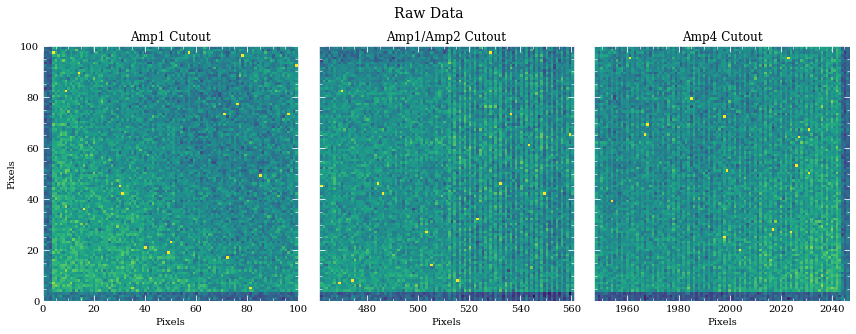

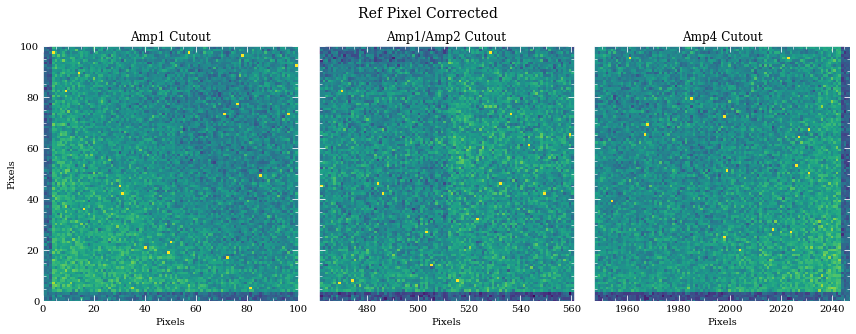

In [6]:
plot_subsections(im_raw, title='Raw Data')
plot_subsections(im_fix, title='Ref Pixel Corrected')

In [20]:
refpix = np.concatenate([data[:,0:4,:], data[:,-4:,:]], axis=1)
refpix = data[:,0:4,:]
refpix_avg = robust.mean(refpix, axis=0)
refpix_sub = refpix - refpix_avg

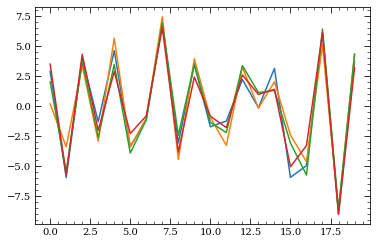

In [21]:
refpix_offsets_ch = np.zeros([nz,nchans])
for ch in range(nchans):
    x1 = ch*chsize
    x2 = x1 + chsize
    refoff_frame = robust.mean(refpix_sub[:,:,x1:x2], axis=(1,2))
    refpix_offsets_ch[:,ch] = refoff_frame

plt.plot(refpix_offsets_ch)

## Superbias Subtraction

It's generally a good idea to subtract a superbias frame prior to the reference pixel correction. This removes the static bias pattern structure in the reference pixels, which allows the averaging function to return a more accurate representation of the frame-to-frame offsets.

In [16]:
# Read in a CV3 dark ramp (first 20 of 108 frames)
# This data is in raw detector coordinates, pixel (0,0) at bottom left
f = '/Users/jarron/NIRCam/Data/CV3_Darks/485/NRCNRCALONG-DARK-53560804151_1_485_SE_2015-12-22T11h59m47.fits'
hdul = fits.open(f)
data = hdul[0].data[0:20].astype('float')
hdul.close()

In [17]:
# Read in super bias image, assumed to be in `det` coords
fbias = '/Users/jarron/NIRCam/dark_analysis/CV3/SUPER_BIAS/SUPER_BIAS_485.FITS'
hdul = fits.open(fbias)
superbias = hdul[0].data.astype('float')
hdul.close()

In [19]:
data -= superbias

In [32]:
superbias[:,0:512] += 100

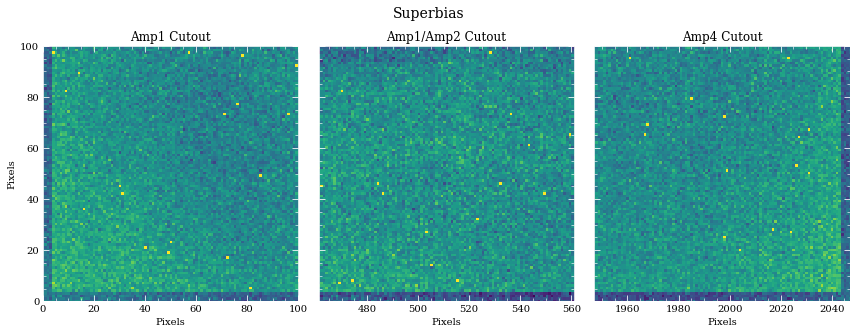

In [33]:
 plot_subsections(superbias, title="Superbias")

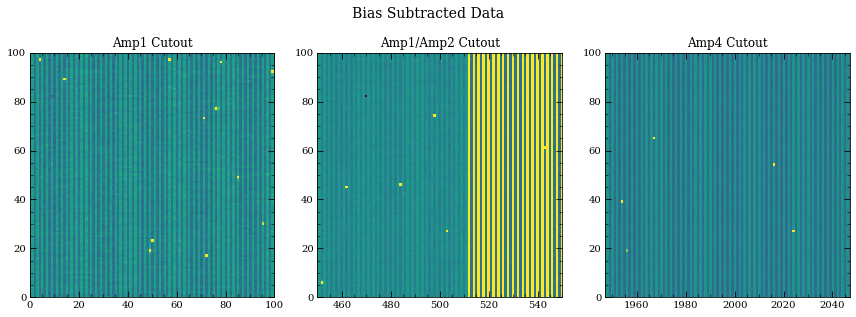

In [20]:
fig, axes = plt.subplots(1,3, figsize=(12,4.5))

titles = ['Amp1 Cutout', 'Amp1/Amp2 Cutout', 'Amp4 Cutout']
x1_arr = [0,450,nx-101]
for i, ax in enumerate(axes):
    x1, x2 = (x1_arr[i], x1_arr[i]+100)
    y1, y2 = (0, 100)

    im = data[10]
    mn = np.median(im[y1:y2, x1:x2])
    std = robust.std(im[y1:y2, x1:x2])
    vmin, vmax = mn + 5*std*np.array([-1,1])
    ax.imshow(im, vmin=vmin, vmax=vmax)

    ax.set_xlim([x1, x2])
    ax.set_ylim([y1, y2])

    ax.set_title(titles[i])

fig.suptitle('Bias Subtracted Data', fontsize=14)
fig.tight_layout()

In [21]:
# Set standard keywords for amplifier offset corrections
kwargs_ref = {
    'nchans': nchans, 'in_place': True, 'altcol': True, 'perint': False,
    'fixcol': True, 'avg_type': 'pixel', 'savgol': True
}
data = ref_pixels.reffix_hxrg(data, **kwargs_ref)

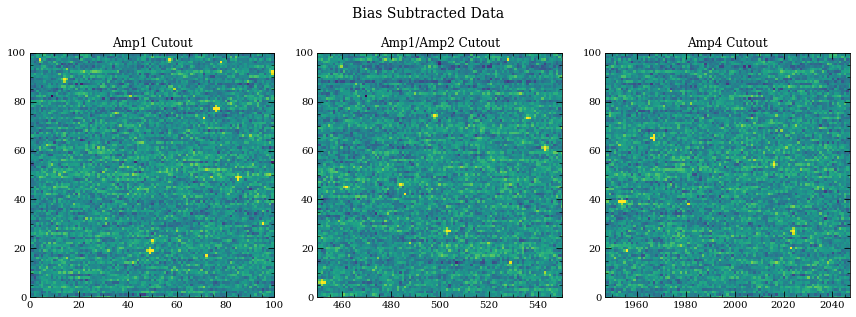

In [22]:
fig, axes = plt.subplots(1,3, figsize=(12,4.5))

titles = ['Amp1 Cutout', 'Amp1/Amp2 Cutout', 'Amp4 Cutout']
x1_arr = [0,450,nx-101]
for i, ax in enumerate(axes):
    x1, x2 = (x1_arr[i], x1_arr[i]+100)
    y1, y2 = (0, 100)

    im = data[10]
    mn = np.median(im[y1:y2, x1:x2])
    std = robust.std(im[y1:y2, x1:x2])
    vmin, vmax = mn + 5*std*np.array([-1,1])
    ax.imshow(im, vmin=vmin, vmax=vmax)

    ax.set_xlim([x1, x2])
    ax.set_ylim([y1, y2])

    ax.set_title(titles[i])

fig.suptitle('Bias Subtracted Data', fontsize=14)
fig.tight_layout()

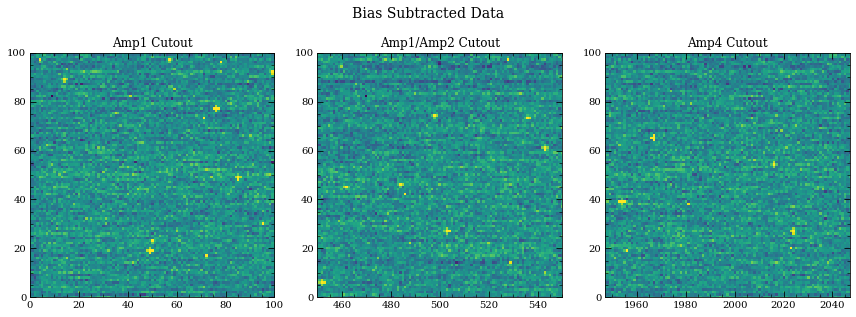

In [56]:
fig, axes = plt.subplots(1,3, figsize=(12,4.5))

titles = ['Amp1 Cutout', 'Amp1/Amp2 Cutout', 'Amp4 Cutout']
x1_arr = [0,450,nx-101]
for i, ax in enumerate(axes):
    x1, x2 = (x1_arr[i], x1_arr[i]+100)
    y1, y2 = (0, 100)

    im = data[10]
    mn = np.median(im[y1:y2, x1:x2])
    std = robust.std(im[y1:y2, x1:x2])
    vmin, vmax = mn + 5*std*np.array([-1,1])
    ax.imshow(im, vmin=vmin, vmax=vmax)

    ax.set_xlim([x1, x2])
    ax.set_ylim([y1, y2])

    ax.set_title(titles[i])

fig.suptitle('Bias Subtracted Data', fontsize=14)
fig.tight_layout()

In [4]:
#data -= superbias

In [6]:
nz, ny, nx = data.shape
nchan = 4
chsize = int(nx/nchan)
refpix = data[:,0:4,:] #np.concatenate([data[:,0:4,:], data[:,-4:,:]], axis=1)

refpix_avg = robust.mean(refpix, axis=0)

refpix_sub = refpix - refpix_avg

In [7]:
refpix.shape

(10, 4, 2048)

In [8]:
refpix_sub = refpix - refpix_avg

In [9]:
refpix_offsets_ch = np.zeros([nz,nchan])
for ch in range(nchan):
    x1 = ch*chsize
    x2 = x1 + chsize
    refoff_frame = robust.mean(refpix_sub[:,:,x1:x2], axis=(1,2))
    refpix_offsets_ch[:,ch] = refoff_frame

plt.plot(refpix_offsets_ch)

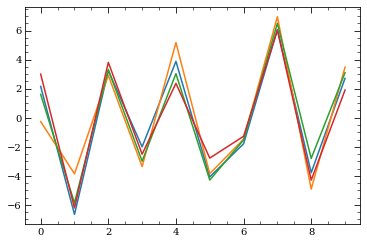

In [10]:
plt.plot(refpix_offsets_ch)

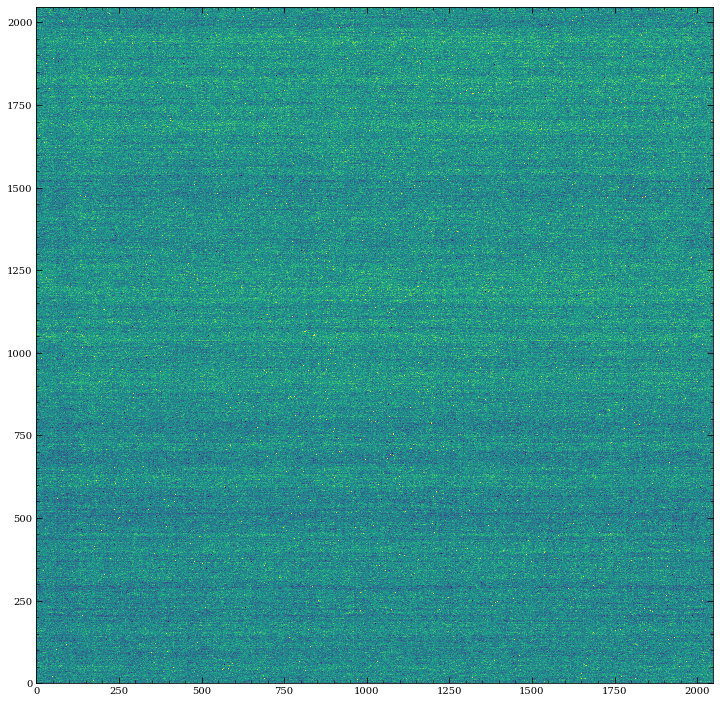

In [59]:
# Plot an image
im = data[0]
ind_nan = np.isnan(im)
mn = np.median(im[~ind_nan])
std = robust.medabsdev(im[~ind_nan])
vmin = mn-5*std
vmax = mn+5*std

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(im, vmin=vmin, vmax=vmax)

fig.tight_layout()